The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
mnist shape :  (784,)
mnist range :  0.0 to 1.0


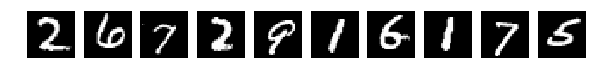


start training
iteration number :  4296
Iter: 0, d_loss : 1.559, g_loss : 0.689, cat_loss : 2.644, conti_loss : 1.394
discriminator output real : 0.50, fake : 0.51


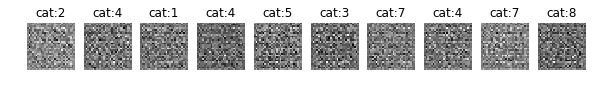

Iter: 250, d_loss : 1.099, g_loss : 0.942, cat_loss : 0.080, conti_loss : 0.986
Iter: 500, d_loss : 0.973, g_loss : 1.003, cat_loss : 0.045, conti_loss : 0.978
discriminator output real : 0.71, fake : 0.62


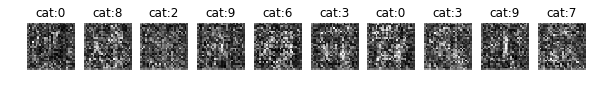

Iter: 750, d_loss : 1.224, g_loss : 0.952, cat_loss : 0.057, conti_loss : 0.961
Iter: 1000, d_loss : 1.212, g_loss : 0.972, cat_loss : 0.029, conti_loss : 0.955
discriminator output real : 0.66, fake : 0.46


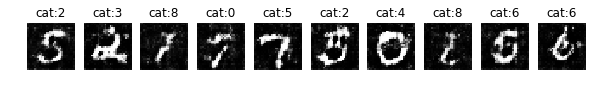

Iter: 1250, d_loss : 1.169, g_loss : 0.936, cat_loss : 0.021, conti_loss : 0.954
Iter: 1500, d_loss : 1.207, g_loss : 0.926, cat_loss : 0.105, conti_loss : 0.959
discriminator output real : 0.64, fake : 0.47


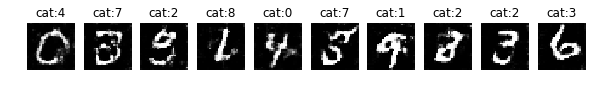

Iter: 1750, d_loss : 1.228, g_loss : 0.959, cat_loss : 0.053, conti_loss : 0.954
Iter: 2000, d_loss : 1.259, g_loss : 0.910, cat_loss : 0.017, conti_loss : 0.953
discriminator output real : 0.56, fake : 0.42


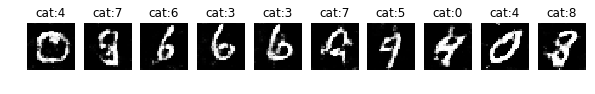

Iter: 2250, d_loss : 1.297, g_loss : 0.919, cat_loss : 0.031, conti_loss : 0.947
Iter: 2500, d_loss : 1.329, g_loss : 0.840, cat_loss : 0.013, conti_loss : 0.953
discriminator output real : 0.59, fake : 0.48


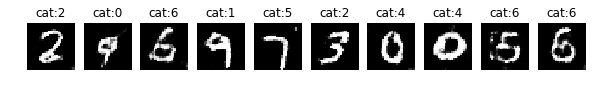

Iter: 2750, d_loss : 1.219, g_loss : 0.934, cat_loss : 0.023, conti_loss : 0.957
Iter: 3000, d_loss : 1.247, g_loss : 0.880, cat_loss : 0.012, conti_loss : 0.943
discriminator output real : 0.50, fake : 0.43


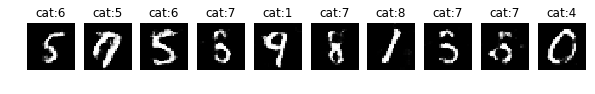

Iter: 3250, d_loss : 1.259, g_loss : 0.891, cat_loss : 0.065, conti_loss : 0.957
Iter: 3500, d_loss : 1.260, g_loss : 0.861, cat_loss : 0.026, conti_loss : 0.945
discriminator output real : 0.63, fake : 0.48


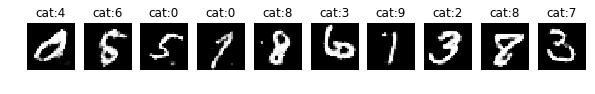

Iter: 3750, d_loss : 1.210, g_loss : 0.917, cat_loss : 0.075, conti_loss : 0.958
Iter: 4000, d_loss : 1.173, g_loss : 0.935, cat_loss : 0.022, conti_loss : 0.946
discriminator output real : 0.64, fake : 0.50


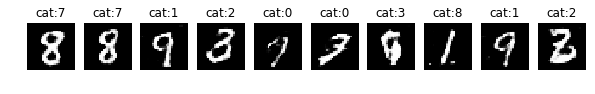

Iter: 4250, d_loss : 1.189, g_loss : 0.935, cat_loss : 0.032, conti_loss : 0.952


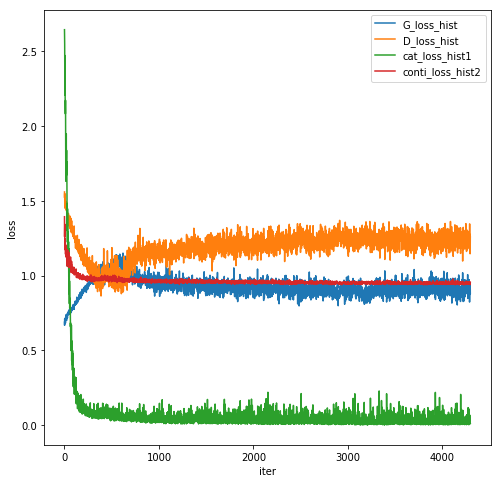

model, configuration saved in file InfoGAN


In [30]:
import tensorflow as tf
from network import *
import train

%load_ext autoreload
%autoreload 2

# command center
batch = 64
latent_dim = 62
cat = 10
conti = 2

layers_d = [('conv1', {'n_out': 64, 'k': 4, 's': 2, 'act': lrelu}),
            ('conv2', {'n_out': 128, 'k': 4, 's': 2, 'act': lrelu, 'batch': True}),
            ('fc3', {'reshape': [-1], 'n_out': 100, 'act': lrelu, 'batch': True}),
            ('fc4', {'n_out': 1})
            ]

layers_q = [('fc1', {'n_out': 128, 'act': lrelu, 'batch': True}),
            ('fc2', {'n_out': cat+conti*2})]

layers_g = [('fc1', {'n_out': 100, 'act': relu, 'batch': True}),
            ('fc2', {'n_out': 7 * 7 * 128, 'act': relu, 'batch': True}),
            ('cnvT3', {'reshape': [7, 7, 128], 'n_out': 64, 'k': 4, 's': 2, 'act': relu, 'batch': True}),
            ('cnvT4', {'n_out': 1, 'k': 4, 's': 2, 'act': tanh})
            ]

gan_type = 'GAN'
loss_lambda = 10.0  # for wGAN_GP

optim_d = {'type': 'adam', 'lr': 2e-4, 'beta1': 0.5, 'beta2': 0.999}
optim_g = {'type': 'adam', 'lr': 1e-3, 'beta1': 0.5, 'beta2': 0.999}
lr_decay_epoch = 5

train_config = {'d_per_g': 1, 'num_epoch': 5, 'show_every': 500, 'print_every': 250}
save_file_dir = "InfoGAN"

tf.reset_default_graph()
# train and save model (configuration is also saved after training)
train.train_mnist_info(layers_d, layers_g, layers_q, gan_type, optim_d, optim_g, lr_decay_epoch,
                       batch, latent_dim, cat, conti, train_config, save_file_dir,
                       fix_std=True, loss_lambda_cat=1, loss_lambda_conti= 1, loss_lambda_gp = loss_lambda, device = '/gpu:0')

INFO:tensorflow:Restoring parameters from InfoGAN.ckpt
model retored
first continuous variance


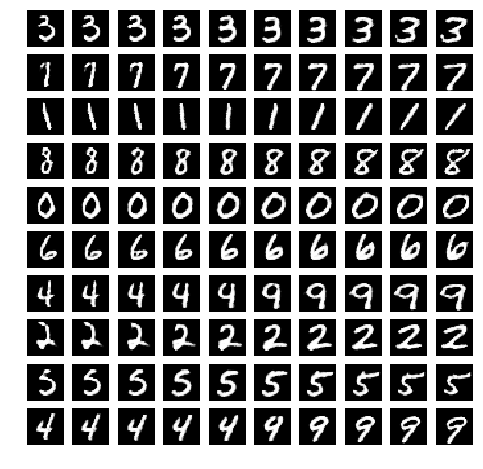

second continuous variance


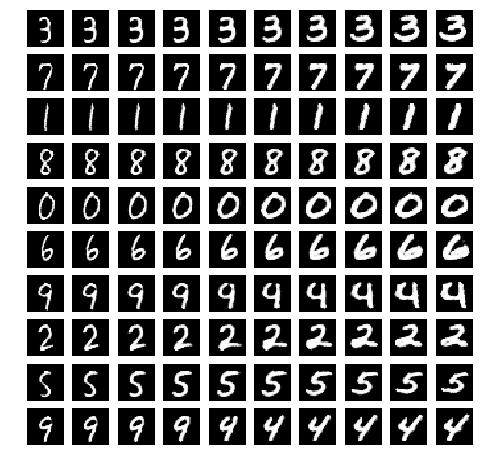

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from data import *

plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
tf.reset_default_graph()

batch = 10
dim = 62
cat = 10
conti = 2

z = tf.placeholder(shape=(batch, latent_dim), dtype=tf.float32)
c1 = tf.placeholder(shape = (batch,cat), dtype = tf.float32)
c2 = tf.placeholder(shape = (batch,conti), dtype = tf.float32)
is_training = tf.placeholder(tf.bool)


# generated images
g_image, g_layers, g_vars, g_moving_avgs = network("generator", tf.concat([z,c1,c2], axis = 1),
                                                           layers_g, is_training=is_training)


saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "InfoGAN.ckpt")
    print("model retored")

    z_noise = np.zeros((batch, dim))
    sam_c1 = np.zeros((batch, cat))
    sam_c2 = np.zeros((batch, conti))

    print("first continuous variance")
    for i in select_list:
        sam_c1[:,i] = 1
        sam_c2[:,0] = np.linspace(-1.5,1.5,10)

        samples = sess.run(g_image, feed_dict={z: z_noise,  c1: sam_c1, c2: sam_c2, is_training: False})
                
        for j in range(10):
            plt.subplot(10,10,i*10+j+1)
            plt.axis('off')
            plt.imshow(samples[j].reshape(28,28))
        
        sam_c2[:,0] = 0
        sam_c1[:,i] = 0
    plt.show()

        
    print("second continuous variance")
    for i in select_list:
        sam_c1[:,i] = 1
        sam_c2[:,1] = np.linspace(-1.5,1.5,10)

        samples = sess.run(g_image, feed_dict={z: z_noise,  c1: sam_c1, c2: sam_c2, is_training: False})
                
        for j in range(10):
            plt.subplot(10,10,i*10+j+1)
            plt.axis('off')
            plt.imshow(samples[j].reshape(28,28))
        
        sam_c2[:,1] = 0
        sam_c1[:,i] = 0
    plt.show()

